In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tools.tools as tools
import split_metrics.gini_impurity as gini

In [2]:
dataset_dict = {
    'tennis': {'label': 'PlayTennis', 'filename': 'play_tennis.csv'},
    'mushrooms' : {'label': 'class', 'filename': 'mushrooms.csv'},
    'iris' : {'label': 'class', 'filename': 'iris.csv'},
    'spambase' : {'label': 'spam', 'filename': 'spambase.csv'},
    'magic_telescope' : {'label': 'class', 'filename': 'magic.csv'},
    'pima' : {'label': 'class', 'filename': 'pima.csv'}
}

In [3]:
class Node:
    def __init__(self):
        self.sons = []

    def add_son(self, question, node):
        self.sons.append((question, node))

    def predict(self, X):
        for question, son in self.sons:
            if question.match(X):
                if isinstance(son, Leaf):
                    return son.label
                else:
                    return son.predict(X)

    def get_accuracy(self, X, y):
        if y.shape[0] == 0:
            return 0
        y = np.array(y)
        predictions = np.array(self.get_predictions(X))
        return (predictions == y).sum() / len(y)

    def get_predictions(self, X):
        predictions = []
        for record_idx, _ in X.iterrows():
            if isinstance(self, Leaf):
                predictions.append(self.label)
            else:
                predictions.append(self.predict(X.loc[record_idx]))
        return predictions

class Leaf:
    def __init__(self, label):
        self.label = label

    def get_accuracy(self, X, y):
        predictions = np.array([self.label] * len(y))
        return (predictions == y).sum() / len(y)
        
    
    def __repr__(self):
        return "--> Predicted value : {}".format(self.label)


class Question:
    def __init__(self, is_continous, attribute, value_list, clf=None):
        self.is_continous = is_continous
        self.attribute = attribute
        self.value_list = value_list
        self.clf = clf

    def match(self, X):
        if self.is_continous:
            # When the data is continuous, each branch represent only one class
            val = self.clf.predict([X])
            return val[0] == self.value_list
        else:
            # Categorical data
            val = X[self.attribute]
            return val in self.value_list

    def __repr__(self):
        rep =''
        if self.is_continous:
            rep = str(self.value_list)
        elif len(self.value_list) == 1:
            rep = str(self.value_list[0])
        else:
            rep = "["
            for idx, val in enumerate(self.value_list):
                aux = ', ' if idx < len(self.value_list) - 1 else ''
                if tools.is_numeric(val):
                    rep += str(round(float(val), 2)) + aux
                else:
                    rep += str(val) + aux
            rep += "]"
        return rep

In [4]:
import numpy as np
import pandas as pd
from sklearn import svm
import tools.tools as tools

class DecisionTree:
    def __init__(self, split_function=gini.get_gini_split):
        self.split_function = split_function
        self.tree = None
        
    def fit(self, X, y):
        self.attribute_list = list(X.columns)
        self.tree = self.__build_tree(X, y, self.attribute_list.copy())

    def predict(self, X):
        node = self.tree
        predictions = []
        for record_idx, _ in X.iterrows():
            if isinstance(node, Leaf):
                predictions.append(node.label)
            else: 
                predictions.append(node.predict(X.loc[record_idx]))
        return predictions

    def score(self, X, y):
        return self.tree.get_accuracy(X, y)
    
    def __build_tree(self, X, y, attribute_list):
        # Only one class left
        left_classes = set(y)
        if len(left_classes) == 1:
            label = list(left_classes)[0]
            return Leaf(label)
        elif not attribute_list:
            # No attribute left to split on, Get most probable class
            label = tools.get_majority_vote(y)
            return Leaf(label)
        else:
            best_attribute, is_continuous = self.__select_attribute(
                    X, y, attribute_list, metric='naive')
            # Create node
            root = Node()
            # Update the attribute list
            attribute_list.remove(best_attribute)
            if is_continuous:
                # Continuous data -> Train an SVM classifier
                clf, X_list, y_list, class_list = self.__split_continuous_data(X, y)
                for data, labels, c in zip (X_list, y_list, class_list):
                    root.add_son(Question(
                        is_continuous, best_attribute, c, clf),
                        self.__build_tree(data, labels, attribute_list))
            else:
                # Categorical data
                # get the branchs and their attribute_value
                data_list, val_list = self.__split_categorical_data(
                        X, best_attribute)
                branch_data = self.__get_clean_branchs(data_list, val_list, y)
                # Add branchs to the node
                for branch, labels, attribute_val_list in branch_data:
                    root.add_son(Question(
                        is_continuous, best_attribute, attribute_val_list),
                        self.__build_tree(branch, labels, attribute_list))
            # Return node
            return root

    def __get_clean_branchs(self, data_list, val_list, y):
        """ Joins together the Leaf branchs with the same label
        Eg:
            - Input:
                - a: val = 0, label = 0
                - b: val = 1, label = 0
                - c: val = 2, label = 1
            - Output:
                - a: val = [0,1], label = 0
                - c: val = [2], label = 1
        @return:
            a list of tuple (X, y, attribute_value) for each branch
        """
        branch_list = []
        branch_dict = {}
        for branch, attribute_val in zip(data_list, val_list):
            branch_labels = y.loc[branch.index]
            item = (branch, branch_labels, [attribute_val])
            labels = list(set(branch_labels))
            if len(labels) == 1:
                # Leaf branch:
                label = labels[0]
                if label in branch_dict:
                    # Label already exists, we update only
                    # the attribute value, X is not important because
                    # it's a leaf node
                    aux = branch_dict[label]
                    aux[2].append(attribute_val)
                    branch_dict[label] = aux
                else:
                    branch_dict[label] = item
            else:
                branch_list.append(item)
        branch_list.extend(branch_dict.values())
        return branch_list
        

    def __select_attribute(self, X, y, attribute_list, metric='naive'):
        """
        @return
            - Continuous data -> (best_attribute, split_candidate)
            - categorical data -> (best_attribute, None)
        """
        # If only one attribute is left and the data is continuous
        # than return the attribute
        if len(attribute_list) == 1 and \
                not tools.is_continuous(X[attribute_list[0]]):
            return (attribute_list[0], None)
        split_list = []
        for attribute in attribute_list:
            # TODO: split_functions should have a default metric argument
            split_score, candidate_split = \
                    self.split_function(X[attribute], y, metric)
            split_list.append(
                    (attribute, split_score, candidate_split))
        # Get best attribute item
        best_attribute_item = max(split_list, key=lambda x: x[1])
        return best_attribute_item[0], best_attribute_item[2]



    def __split_categorical_data(self, X, attribute): 
        branch_data_list = []; attribute_value_list = []
        for attribute_val, branch_data in X.groupby(X[attribute]):
            attribute_value_list.append(attribute_val)
            branch_data_list.append(branch_data)
        return branch_data_list, attribute_value_list
    
    def __split_continuous_data(self, X, y):
        clf = svm.LinearSVC()
        clf.fit(X, y)
        predicted_classes = clf.predict(X)
        X_list = []; y_list = []; class_list = []
        for c in np.unique(predicted_classes):
            sample_idxs = np.where(predicted_classes == c)
            # we have the index of the sample in the array not in the
            # dataframe -> use iloc instead of loc
            X_list.append(X.iloc[sample_idxs])
            y_list.append(y.iloc[sample_idxs])
            class_list.append(c)
        return clf, X_list, y_list, class_list

In [27]:
dataset = 'iris'; train_percent = .8; test_percent = .2
data, label, attribute_list = tools.get_dataset(dataset, dataset_dict)
train, validation, test = tools.train_test_split(
    data[attribute_list], data[label], train_percent, test_percent)
decision_tree = DecisionTree(gini.get_gini_split)
decision_tree.fit(train[0], train[1])
print("Score : ", decision_tree.score(test[0], test[1]))
#tools.generate_tree_graph(decision_tree.tree, data[label].unique())

Score :  0.966666666667


In [5]:
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA

mnist = fetch_mldata("MNIST original")
# rescale the data
X, y = mnist.data / 255., mnist.target
def reduce_dim(X, nb_features=2):
    # Dimensionality reduction with PCA
    pca = PCA(n_components=nb_features)
    pca.fit(X)
    X = pca.transform(X)
    return X

def get_dataframe(X, y, nb_features=2, label='class'):
    if X.shape[0] > nb_features:
        X = reduce_dim(X, nb_features)
    # Set label and attribute list
    attribute_list = ['feature_' + str(i) for i in range(nb_features)]
    # Converty data to dataframe
    dataframe = pd.DataFrame(data=X, columns=attribute_list)
    dataframe[label] = y
    # Shuffle data
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    return (dataframe, attribute_list, label)

data, attribute_list, label = get_dataframe(X, y, nb_features=10)
data.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,class
0,2.000026,-0.854957,2.249496,0.574057,1.708674,0.580487,-0.287444,-1.197101,1.238749,2.006146,2.0
1,-1.082991,-2.032074,-0.401113,0.773354,-0.516637,2.004990,-2.076238,0.113530,-1.956407,-0.278100,2.0
2,0.683354,2.822015,-0.418692,1.664834,-1.719569,-0.423130,-2.459616,0.019952,-1.049108,0.833671,4.0
3,4.146275,-1.067133,2.754901,-0.955500,-3.203380,-1.346798,-0.281731,-1.252539,-0.498036,0.647986,0.0
4,-2.514917,-2.392069,1.806564,0.761345,0.750094,2.802187,-2.784712,-0.293249,0.503525,0.542812,1.0


In [31]:
nb_feat =10; train_percent = .8; test_percent = .2
data, attribute_list, label = get_dataframe(X, y, nb_feat)
train, validation, test = tools.train_test_split(
        data[attribute_list], data[label], train_percent, test_percent)
decision_tree = DecisionTree(gini.get_gini_split)
decision_tree.fit(train[0], train[1])
print("Nb feat = ", nb_feat, ", Score : ", decision_tree.score(test[0], test[1]))
generate_tree_graph(decision_tree.tree, data[label].unique())

Nb feat =  10 , Score :  0.776142857143


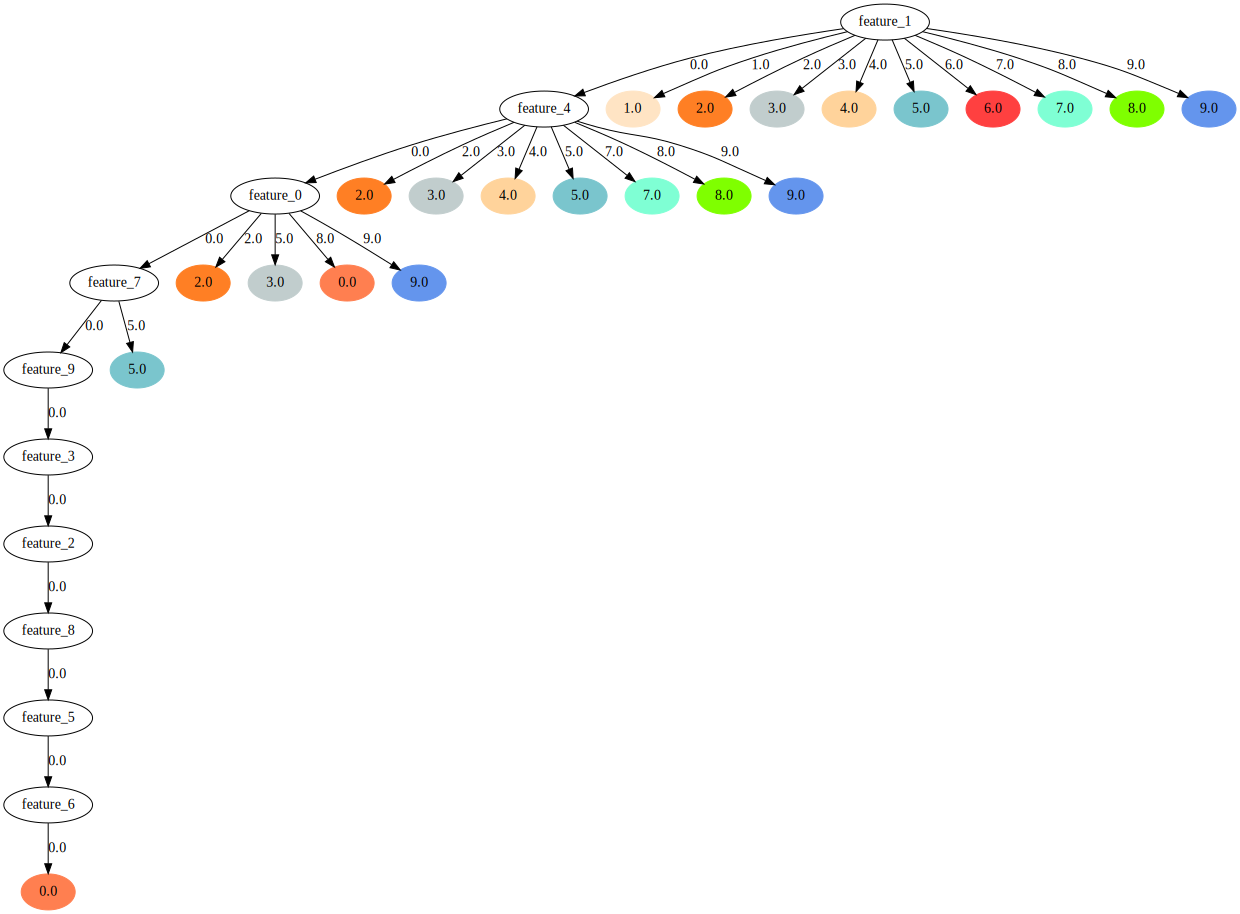

In [34]:
generate_tree_graph(decision_tree.tree, data[label].unique())

In [ ]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

models = [DecisionTree(gini.get_gini_split), DecisionTreeClassifier(), svm.SVC(),
          GaussianNB(), LinearDiscriminantAnalysis(n_components=2)]
models_dict = {
    0 : 'decision_tree',
    1 : 'decision_tree sklearn',
    2 : 'svm',
    3 : 'gaussian',
    4 : 'lda'
}

def custom_plot(graph_dict, y_values, title):
    x_val = list(range(1, len(train_acc[1]) + 1))
    for graph_idx in graph_dict.keys():
        plt.ylim(ymin=0., ymax=1.1)
        plt.plot(x_val, y_values[graph_idx], label=graph_dict[graph_idx])
        plt.xticks(x_val)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.ylabel('Accuracy')
        plt.xlabel('fold index')
        plt.title(title, y=1.08, fontweight="bold")
    plt.grid()
    plt.show()
    
def benchmark_models(models, models_dict, dataset_dict,
                     nb_folds=5, dataset_name='iris'):
    nb_feat = 10
    #data, attribute_list, label = get_dataframe(X, y, nb_feat)
    data, label, attribute_list = tools.get_dataset(dataset_name, dataset_dict)
    nb_models = len(models)
    train_acc = np.zeros((nb_models, nb_folds))
    test_acc = np.zeros((nb_models, nb_folds))

    k_idx = 0
    kf = KFold(n_splits=nb_folds, shuffle=True, random_state=48)
    for train_idxs, test_idxs in kf.split(data):
        print(k_idx)
        # Set up data
        X_train, X_test = data.iloc[train_idxs], data.iloc[test_idxs]
        y_train, y_test = X_train[label], X_test[label]
        X_train, X_test = X_train[attribute_list], X_test[attribute_list]
        # Train models
        model_idx = 0
        for model in models:
            if model_idx == 0:
                model.fit(X_train, y_train)
                y_train, y_test = np.array(list(y_train)), np.array(list(y_test))
            else:
                model.fit(X_train, y_train)
            train_acc[model_idx, k_idx] = model.score(X_train, y_train)
            test_acc[model_idx, k_idx] = model.score(X_test, y_test)
            model_idx += 1

        k_idx += 1
    return train_acc, test_acc

train_acc, test_acc = benchmark_models(models, models_dict, dataset_dict,
                                       dataset_name='magic_telescope', nb_folds=5)

In [ ]:
custom_plot(models_dict, train_acc, 'Train accuracy')
custom_plot(models_dict, test_acc, 'Test accuracy')
print("Train accuracy: ", np.mean(train_acc, axis=0)
print("Test accuracy: ", np.mean(test_acc, axis=0)

     Dtree  | Dtree_sk | SVM   | Gaussian |  LDA 
    --------|----------|-------|----------|-------
     88.52  |  88.52   | 88.52 |  88.52   | 88.52

In [26]:
np.mean(test_acc, axis=1)

array([ 0.68054679,  0.81561514,  0.65567823,  0.        ])

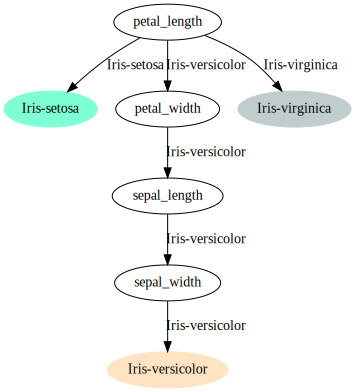

In [26]:
from graphviz import Digraph
import uuid

def generate_tree_graph(tree, labels,
        graph_name="decision_tree_train", display=False):
    dot = Digraph()
    root_node_id = uuid.uuid4()
    label_color_dict = get_label_colors(labels)
    generate_tree_graph_aux(dot, tree, root_node_id, label_color_dict)
    if display:
        dot.render('tree_graph/' + graph_name, view=True)
    else:
        dot.render('tree_graph/' + graph_name, view=False)
    return dot

def data_encoder(data):
    """Transforms the data features from string to int"""
    for column in list(data.columns):
        if not is_continuous(data[column]):
            for idx, val in enumerate(data[column].unique()):
                data.loc[data[column] == val, column] = idx
    return data

def generate_tree_graph_aux(dot, node, root_node_id,
        label_color_dict):
    if isinstance(node, Leaf):
        color = label_color_dict[node.label]
        dot.node(str(uuid.uuid4()), str(node.label),
                style="filled", fillcolor=color, color=color)
    else:
        dot.node(str(root_node_id), node.sons[0][0].attribute)
        for question, son in node.sons:
            node_id = uuid.uuid4()
            if isinstance(son, Leaf):
                color = label_color_dict[son.label]
                dot.node(str(node_id), str(son.label),
                        style="filled", fillcolor=color, color=color)
                dot.edge(str(root_node_id), str(node_id),
                        label=str(question))
            else:
                generate_tree_graph_aux(dot, son, node_id,
                        label_color_dict)
                dot.edge(str(root_node_id), str(node_id),
                        label=str(question))

def get_label_colors(labels):
    node_colors = ['aquamarine', 'bisque', 'azure3', 'brown1',
        'burlywood1', 'cadetblue3', 'chartreuse', 'chocolate1',
        'coral', 'cornflowerblue', 'darkgoldenrod1', 'darkgreen',
        'darkolivegreen1', 'darkorange1', 'darkturquoise',
        'deeppink', 'dimgray', 'gold3', 'gray42', 'greenyellow']
    label_dict = {}
    for idx, label in enumerate(labels):
        label_dict[label] = node_colors[idx] \
                if idx < len(node_colors) else node_colors[0]
    return label_dict

generate_tree_graph(decision_tree.tree, data[label].unique())

In [71]:
decision_tree.tree.sons

[(<__main__.Question at 0x7fa71c6cc320>, --> Predicted value : Iris-setosa),
 (<__main__.Question at 0x7fa71c6cc2b0>, <__main__.Node at 0x7fa71c6cc160>),
 (<__main__.Question at 0x7fa71c6cca90>, --> Predicted value : Iris-virginica)]